In [1]:
import os
if os.getcwd().split("/")[-1] != 'BENDR-XAI': os.chdir("../")

import mne
import numpy as np
import matplotlib.pyplot as plt
from utils import *

from matplotlib import animation
import matplotlib.cm as cm
import sys
from tqdm import tqdm

## Test

In [2]:
edf_file_path = 'notebooks/S001R10.edf'

/home/andersgm/anaconda3/envs/XAI/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


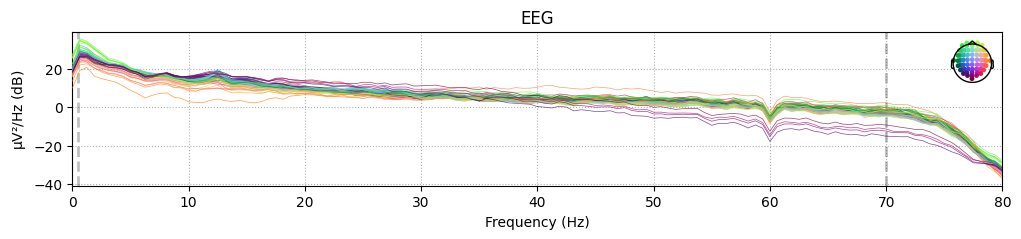

In [3]:
subjects_dir, subject, trans, src_path, bem_path = get_fsaverage()
raw = get_raw(edf_file_path)

fig, ax = plt.subplots(1, 1, figsize=(12, 2))
raw.compute_psd(verbose = False).plot(axes = ax)
plt.show()

In [4]:
src = get_src(src_path)
fwd = get_fwd(raw.info, trans, src_path, bem_path)
cov = get_cov(raw)

In [5]:
stc = get_stc(raw, fwd, cov, tmin=2, tmax=4)

In [6]:
mne.datasets.fetch_hcp_mmp_parcellation(subjects_dir=subjects_dir, accept=True)
parcellation_name = "aparc_sub" #HCPMMP1
labels_lh = mne.read_labels_from_annot('fsaverage', parcellation_name, 'lh', subjects_dir=subjects_dir, verbose=False) 
labels_rh = mne.read_labels_from_annot('fsaverage', parcellation_name, 'rh', subjects_dir=subjects_dir, verbose=False)
labels = [labels_lh, labels_rh]

In [7]:
vertices = get_vertices(src)
tris_vertices = get_vertices_tris(src)

sources = get_sources(src)
tris_sources = get_sources_tris(src)

In [12]:
# tris_values = get_z_values(sources, tris_sources)
# tris_colors = cm.viridis(tris_values)

# for hemi in range(2):
#     for i in tqdm(range(len(labels[hemi]))):
#         region_source_indices = labels[hemi][i].get_vertices_used()

#         file_name = Path("data") / "processed" / "{}_{}_{}_tris_sources_indices.npy".format(parcellation_name, ["lh", "rh"][hemi], i)

#         if os.path.exists(file_name):
#             region_tris_indices = np.load(file_name)
#         else:
#             region_tris_indices = get_tris_idx(region_source_indices, tris_sources[hemi])
#             np.save(file_name, region_tris_indices)

#         tris_colors[hemi][region_tris_indices] = np.array(cm.viridis(i / len(labels[hemi])))


tris_values = get_z_values(vertices, tris_vertices)
tris_colors = cm.viridis(tris_values)

for hemi in range(2):
    for i in tqdm(range(len(labels[hemi]))):
        region_vertex_indices = labels[hemi][i].vertices

        file_name = Path("data") / "processed" / "{}_{}_{}_tris_vertices_indices.npy".format(parcellation_name, ["lh", "rh"][hemi], i)

        if os.path.exists(file_name):
            region_tris_indices = np.load(file_name)
        else:
            region_tris_indices = get_tris_idx(region_vertex_indices, tris_vertices[hemi])
            np.save(file_name, region_tris_indices)

        tris_colors[hemi][region_tris_indices] = np.array(cm.tab20(i / len(labels[hemi])))

100%|██████████| 224/224 [00:04<00:00, 47.91it/s]


In [14]:
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(1, 1, 1, projection='3d')

# for i in range(2):
#     mesh = ax.plot_trisurf(*sources[i].T, triangles=tris_sources[i], linewidth=0.1, shade=False,
#                             antialiased=True, edgecolor=(0,0,0,0.5))

#     mesh.set_facecolors(tris_colors[i])

# ax.set_xlim(-0.06, 0.06)
# ax.set_ylim(-0.08, 0.04)
# ax.set_zlim(-0.04, 0.09)
# ax.set_box_aspect([1,1,1])
# ax.view_init(45, 90)
# ax.axis("off")
# fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

# plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')

for i in range(2):
    mesh = ax.plot_trisurf(*vertices[i].T, triangles=tris_vertices[i], linewidth=0.1, shade=False,
                            antialiased=True, edgecolor=(0,0,0,0.5))

    mesh.set_facecolors(tris_colors[i])

ax.set_xlim(-0.06, 0.06)
ax.set_ylim(-0.08, 0.04)
ax.set_zlim(-0.04, 0.09)
ax.set_box_aspect([1,1,1])
ax.view_init(45, 90)
ax.axis("off")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

plt.show()

qt.qpa.plugin: Could not load the Qt platform plugin "wayland" in "" even though it was found.
qt.qpa.plugin: Could not load the Qt platform plugin "wayland" in "" even though it was found.


Using matplotlib backend: <object object at 0x7fb19011f6d0>


In [335]:
activity = [np.empty(len(labels[0])), np.empty(len(labels[1]))]

for hemi in range(2):
    for i in range(len(labels[hemi])):
        activity[hemi][i] = np.sum(stc.in_label(labels[hemi][i]).data**2)

In [346]:
min_act = np.min(np.concatenate((activity[0], activity[1])))

In [347]:
min_act = np.min(np.concatenate((activity[0], activity[1])))
max_act = np.max(np.concatenate((activity[0], activity[1])))

activity[0] = (activity[0] - min_act) / (max_act - min_act)
activity[1] = (activity[1] - min_act) / (max_act - min_act)

In [348]:
values = np.zeros(sources.shape[:2])

In [349]:
for hemi in range(2):
    for i in range(len(labels[hemi])):
        values[hemi][labels[hemi][i].get_vertices_used()] = activity[hemi][i]

In [350]:
tris_values = get_z_values(sources, tris_sources)
tris_colors = cm.viridis(tris_values)

for hemi_idx in range(2):
    for i in tqdm(range(len(labels[hemi_idx]))):
        region_source_indices = labels[hemi_idx][i].get_vertices_used()
        region_tris_indices = get_tris_idx(region_source_indices, tris_sources[hemi_idx])
        tris_colors[hemi_idx][region_tris_indices] = cm.viridis(values[hemi][i])

100%|██████████| 224/224 [00:38<00:00,  5.85it/s]


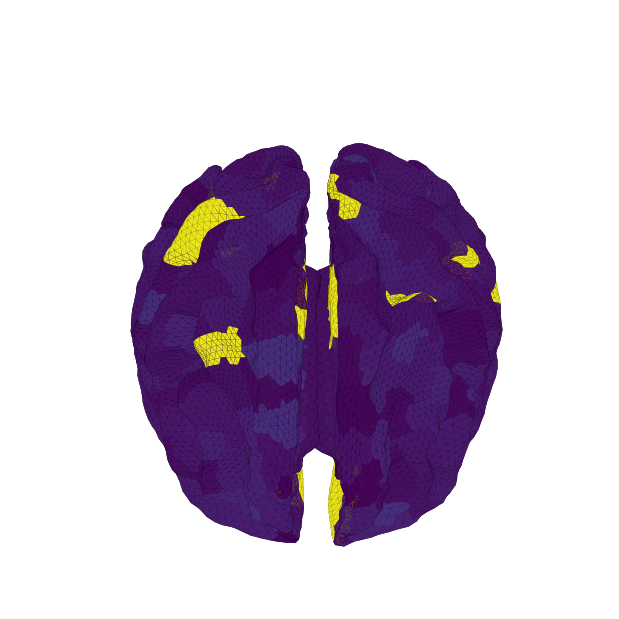

In [351]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')

for i in range(2):
    mesh = ax.plot_trisurf(*sources[i].T, triangles=tris_sources[i], linewidth=0.1, shade=False,
                            antialiased=True, edgecolor=(0,0,0,0.5))

    mesh.set_facecolors(tris_colors[i])

ax.set_xlim(-0.06, 0.06)
ax.set_ylim(-0.08, 0.04)
ax.set_zlim(-0.04, 0.09)
ax.set_box_aspect([1,1,1])
ax.view_init(45, 90)
ax.axis("off")
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
#fig.colorbar(cm.ScalarMappable(cmap='viridis'))

plt.show()